# MLM_finetuning_checkpoint_test
- 다른 ipynb 파일에서 전처리를 진행후 생성된 csv 파일로 본 학습이 진행된다.

## 1. Import 및 라이브러리 설치

In [1]:
import gc
import torch
import sys

gc.collect()
torch.cuda.empty_cache()

In [2]:
!pip install rouge_score
!pip install datasets==1.0.2
!pip install transformers==4.24.0
!pip install transformer-utils
!pip install packaging
!pip install wandb

In [3]:
# mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-11-22 03:21:11--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-11-22 03:21:11--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc65d4455993d3a62a8034eadee4.dl.dropboxusercontent.com/cd/0/get/BxMp3Kz7hktiXN2Yi77wYOUWAfH4BFjpgeZ010cPt2JHu55Nkd7EYmRodGDCYuI3-uCVUPrxRL1WAuF3NhQ11q_YwS1-m_9hQOiVVRysMPTgFfRG8y1DC2rvAjEMo55RAx3KMMQBd4rfCi77s8XoaJwkGYLbaA8wohgMQ3nB9wkrrtE4AOBeGVTR3SU8Ck3Iems/file?dl=1# [following]
--2022-11-22 03:21:12--  https://uc65d4455993d3a62a8034eadee4.dl.dropboxusercontent.com/cd/0/get/BxMp3Kz7hkti

In [4]:
# 필요한 라이브러리 불러오기
import datasets
import transformers
import pandas as pd
from datasets import Dataset



import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    LineByLineTextDataset,
    BartTokenizer,
    BartForConditionalGeneration,
    EarlyStoppingCallback
    

)

from transformers import RobertaTokenizerFast
from transformers import EncoderDecoderModel
from dataclasses import dataclass, field
from typing import Optional
from datasets import load_dataset, load_from_disk
from tqdm import tqdm
from tabulate import tabulate
from konlpy.tag import Mecab

## 2. 모델 및 데이터 불러오기

### 1) 모델 불러오기

In [5]:
model_checkpoints = "/aiffel/aiffel/Korean_Conversation_Summary/MLM_ft2/checkpoint-4000" #MLM_pretrain_basev2_total10ep/checkpoint-14000" #/MLM_ft/checkpoint-4000"#"/aiffel/aiffel/Korean_Conversation_Summary/MLM_pretrain_5ep_221120_2/checkpoint-87500"#"gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints) 

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


### 2) 데이터 불러오기 및 확인

In [6]:
train_category_path = "data/train_category.csv"
val_category_path = "data/val_category.csv"

with open(train_category_path, encoding="utf-8") as f:
            train_category = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

with open(val_category_path, encoding="utf-8") as f:
            val_category = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

In [7]:
train_textfile_path = "data/train_text.csv"
train_summaryfile_path = "data/train_summary.csv"

with open(train_textfile_path, encoding="utf-8") as f:
            train_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

with open(train_summaryfile_path, encoding="utf-8") as f:
            train_sumlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]          

In [8]:
val_textfile_path = "data/val_text.csv"
val_summaryfile_path = "data/val_summary.csv"

with open(val_textfile_path, encoding="utf-8") as f:
            val_textlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

with open(val_summaryfile_path, encoding="utf-8") as f:
            val_sumlines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]          

In [9]:
del train_textlines[0]
del val_textlines[0]
del train_category[0]
del val_category[0]
del val_sumlines[0]
del train_sumlines[0]

In [10]:
test= pd.read_csv("data/train_text.csv")

In [11]:
test['Text'][0]

'그럼 날짜는 가격 큰 변동 없으면 6 28-7 13로 확정할까 우리 비행포함 15일이야 16일 아 너 나한테 돈 보내주면 지금 할 수 잇옹 얼마야 최종 결제액이 잠시만 인당 952 900 합쳐서 1 905 800 근데 나중에 특가 뜰 수도 있으려나 좀 더 두고볼까 뜨기야 뜨겠지 웅웅 보니까 아시아나는 특가 이벤트 꽤 하는 것 같아서 일단 두고보장 그래 구럼 일단 자자'

In [12]:
train_textlines[0]

'그럼 날짜는 가격 큰 변동 없으면 6 28-7 13로 확정할까 우리 비행포함 15일이야 16일 아 너 나한테 돈 보내주면 지금 할 수 잇옹 얼마야 최종 결제액이 잠시만 인당 952 900 합쳐서 1 905 800 근데 나중에 특가 뜰 수도 있으려나 좀 더 두고볼까 뜨기야 뜨겠지 웅웅 보니까 아시아나는 특가 이벤트 꽤 하는 것 같아서 일단 두고보장 그래 구럼 일단 자자'

### 3) 메타 데이터 적용

In [13]:
for i in range(len(val_textlines)):
    temp_cat = "#"+val_category[i]+"# "
    val_textlines[i] = temp_cat+val_textlines[i]

In [14]:
for i in range(len(train_textlines)):
    temp_cat = "#"+train_category[i]+"# "
    train_textlines[i] = temp_cat+train_textlines[i]

### 4) DataFrame로 적용

In [15]:
train_df = pd.DataFrame(zip(train_textlines, train_sumlines), columns=['Text', 'Summary'])
val_df = pd.DataFrame(zip(val_textlines, val_sumlines), columns=['Text', 'Summary'])

In [16]:
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

In [17]:
train_df.head()

,Text,Summary
0,#상거래(쇼핑)# 그럼 날짜는 가격 큰 변동 없으면 6 28-7 13로 확정할까 우...,비행기 표 가격에 대해 이야기하며 특가 이벤트를 기다리고 있다
1,#상거래(쇼핑)# kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마...,비염이 있어서 싸게 나온 일회용 부직포 마스크를 사두려고 한다
2,#상거래(쇼핑)# 아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 ...,케이크 업체 중 중앙동 쪽은 맛만 있고 디자인은 별로고 고잔동 케이크 업체는 배달도...
3,#상거래(쇼핑)# 칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남 아 그 왕...,칫솔을 3개월에 하나씩 바꿔서 왕 칫솔 사러 신세계 가자고 했다
4,#상거래(쇼핑)# 잠도안오네 얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보...,잠도 안 와서 고구마 말랭이를 양심상 하나만 먹으려고 한다


## 3. 데이터 EDA

In [18]:
# Mecab 적용 후 문장 len 출력하는 함수 구현 - 전체 데이터

# 한글 데이터 Mecab 적용하기
mecab = Mecab()

def sentence_len_total(data):

    # 빈 리스트 적용
    text_split_text = []
    text_split_summary = []
    
    # 반복문으로 Mecab 적용
    for text_sen in data['Text'].iloc[range(0, len(data))]:
        text_split_text.append(mecab.morphs(text_sen))

    for summary_sen in data['Summary'].iloc[range(0, len(data))]:
        text_split_summary.append(mecab.morphs(summary_sen))
    
    df_ext = pd.DataFrame(zip(text_split_text,text_split_summary),\
                          columns=['Text', 'Summary'])

    
    # Mecab 적용 후 길이 출력
    text_len = df_ext.Text.map(len)
    headlines_len = df_ext.Summary.map(len)
    
    # text_len 사분위수 구하기
    
    text_Q1 = text_len.quantile(.25)
    text_Q3 = text_len.quantile(.75)
    text_IQR = text_Q3 - text_Q1
    text_Q2 = text_len.quantile(.5)
    text_Q4 = text_len.quantile(1)
    text_threshold_len_left = text_Q1 - (1.5 * text_IQR)
    text_threshold_len_right = text_Q3 + (1.5 * text_IQR)
    # headlines_len 사분위수 구하기
    
    headlines_Q1 = headlines_len.quantile(.25)
    headlines_Q3 = headlines_len.quantile(.75)
    headlines_IQR = headlines_Q3 - headlines_Q1
    headlines_Q2 = headlines_len.quantile(.5)
    headlines_Q4 = headlines_len.quantile(1)
    headlines_threshold_len_left = headlines_Q1 - (1.5 * headlines_IQR)
    headlines_threshold_len_right = headlines_Q3 + (1.5 * headlines_IQR)
    
    print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
    print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
    print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
    
    print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
    print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
    print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
    

    
    print('text_Q1 = {}'.format(text_Q1), 'headlines_Q1 = {}'.format(headlines_Q1))
    print('text_Q3 = {}'.format(text_Q3), 'headlines_Q3 = {}'.format(headlines_Q3))
    print('text_IQR = {}'.format(text_IQR), 'headlines_IQR = {}'.format(headlines_IQR))
    print('text_Q2 = {}'.format(text_Q2), 'headlines_Q2 = {}'.format(headlines_Q2))
    print('text_Q4 = {}'.format(text_Q4), 'headlines_Q4 = {}'.format(headlines_Q4))
    print('텍스트의 왼쪽 울타리 범위 : {}'. format(text_threshold_len_left),
         '텍스트의 오른쪽 울타리 범위 : {}'. format(text_threshold_len_right))
    print('헤드라인의 왼쪽 울타리 범위 : {}'. format(headlines_threshold_len_left),
         '헤드라인의 오른쪽 울타리 범위 : {}'. format(headlines_threshold_len_right))
    
    plt.subplot(1,2,1)
    plt.boxplot(text_len)
    plt.title('text')
    plt.subplot(1,2,2)
    plt.boxplot(headlines_len)
    plt.title('headlines')
    plt.tight_layout()
    plt.show()

    plt.title('text')
    plt.hist(text_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    plt.title('headlines')
    plt.hist(headlines_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

텍스트의 최소 길이 : 12
텍스트의 최대 길이 : 928
텍스트의 평균 길이 : 60.59299908568816
헤드라인의 최소 길이 : 4
헤드라인의 최대 길이 : 77
헤드라인의 평균 길이 : 20.006135889596845
text_Q1 = 43.0 headlines_Q1 = 15.0
text_Q3 = 71.0 headlines_Q3 = 24.0
text_IQR = 28.0 headlines_IQR = 9.0
text_Q2 = 55.0 headlines_Q2 = 19.0
text_Q4 = 928.0 headlines_Q4 = 77.0
텍스트의 왼쪽 울타리 범위 : 1.0 텍스트의 오른쪽 울타리 범위 : 113.0
헤드라인의 왼쪽 울타리 범위 : 1.5 헤드라인의 오른쪽 울타리 범위 : 37.5


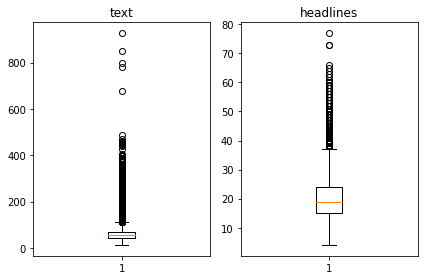

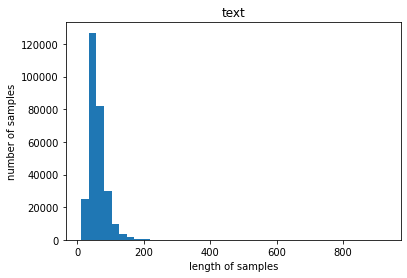

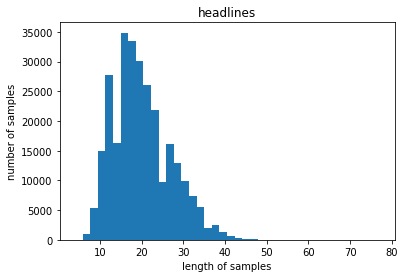

In [19]:
sentence_len_total(train_df)

텍스트의 최소 길이 : 14
텍스트의 최대 길이 : 552
텍스트의 평균 길이 : 60.8691292423723
헤드라인의 최소 길이 : 4
헤드라인의 최대 길이 : 62
헤드라인의 평균 길이 : 20.01356987772826
text_Q1 = 44.0 headlines_Q1 = 15.0
text_Q3 = 72.0 headlines_Q3 = 24.0
text_IQR = 28.0 headlines_IQR = 9.0
text_Q2 = 56.0 headlines_Q2 = 19.0
text_Q4 = 552.0 headlines_Q4 = 62.0
텍스트의 왼쪽 울타리 범위 : 2.0 텍스트의 오른쪽 울타리 범위 : 114.0
헤드라인의 왼쪽 울타리 범위 : 1.5 헤드라인의 오른쪽 울타리 범위 : 37.5


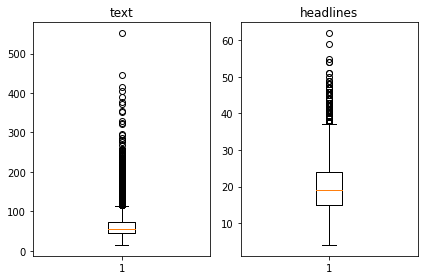

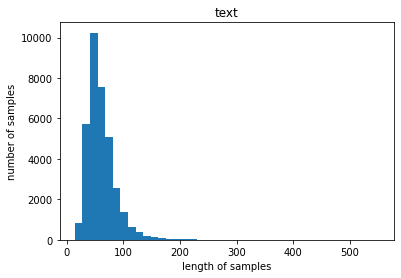

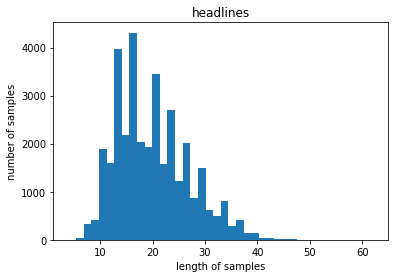

In [20]:
sentence_len_total(val_df)

In [21]:
train_df.head()

,Text,Summary
0,#상거래(쇼핑)# 그럼 날짜는 가격 큰 변동 없으면 6 28-7 13로 확정할까 우...,비행기 표 가격에 대해 이야기하며 특가 이벤트를 기다리고 있다
1,#상거래(쇼핑)# kf마스크만 5부제 하는거지 응 면마스크는 아무때나 사도될껀 면마...,비염이 있어서 싸게 나온 일회용 부직포 마스크를 사두려고 한다
2,#상거래(쇼핑)# 아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디자인은 ...,케이크 업체 중 중앙동 쪽은 맛만 있고 디자인은 별로고 고잔동 케이크 업체는 배달도...
3,#상거래(쇼핑)# 칫솔사야하는데 쓱으로 살까 뭘 칫솔사는것까지 물어보시남 아 그 왕...,칫솔을 3개월에 하나씩 바꿔서 왕 칫솔 사러 신세계 가자고 했다
4,#상거래(쇼핑)# 잠도안오네 얼릉 고구마츄 먹고싶단 그게 그렇게 맛있었어 아주 여보...,잠도 안 와서 고구마 말랭이를 양심상 하나만 먹으려고 한다


## 4. 데이터 토큰화

### 1) dataset으로 변환

In [22]:
# DF > data Set으로 전환
train_len = len(train_df) // 4
train_data = Dataset.from_pandas(train_df[:train_len]) 
val_len = len(val_df) // 2
val_data = Dataset.from_pandas(val_df[:val_len])
test_data=Dataset.from_pandas(val_df[val_len:])

In [23]:
print(train_data)
print(val_data)
print(test_data)

Dataset(features: {'Text': Value(dtype='string', id=None), 'Summary': Value(dtype='string', id=None)}, num_rows: 69998)
Dataset(features: {'Text': Value(dtype='string', id=None), 'Summary': Value(dtype='string', id=None)}, num_rows: 17502)
Dataset(features: {'Text': Value(dtype='string', id=None), 'Summary': Value(dtype='string', id=None)}, num_rows: 17502)


### 2) EDA 바탕으로 길이 지정

In [24]:
max_input = 70
max_target = 30
batch_size = 4
ignore_index = -100# tokenizer.pad_token_id

### 3) 토큰화 함수 구현 및 토큰화
- input_ids, attention_mask, lables토큰만 구현
- 추가로 decoder_input_ids, decoder_attention_mask 토큰화도 시도해봤으나 성능에는 차이가 없고 허깅페이스에 그에 관한 설명이 나왔있음
    - https://huggingface.co/docs/transformers/glossary#decoder-input-ids

In [25]:
 def add_ignored_data(inputs, max_len, ignore_index):
        if len(inputs) < max_len:
            pad = [ignore_index] *(max_len - len(inputs)) # ignore_index즉 -100으로 패딩을 만들 것인데 max_len - lne(inpu)
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:max_len]

        return inputs

In [26]:
def add_padding_data(inputs, max_len):
        pad_index = tokenizer.pad_token_id
        if len(inputs) < max_len:
            pad = [pad_index] *(max_len - len(inputs))
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:max_len]

        return inputs 


In [27]:
def preprocess_data(data_to_process):
    label_id= []
    label_ids = []
    dec_input_ids = []
    inputs = [dialogue for dialogue in data_to_process['Text']]
    model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)

    for i in range(len(data_to_process['Summary'])):
        label_id.append(tokenizer.encode(data_to_process['Summary'][i]))  
    for i in range(len(data_to_process['Summary'])):
        label_id[i].append(tokenizer.eos_token_id)
        label_ids.append(add_ignored_data(label_id[i], max_target, ignore_index))
#    for i in range(len(data_to_process['Summary'])):  
#        dec_input_id = [tokenizer.eos_token_id]
#        dec_input_id += label_ids[i][:-1]
#        dec_input_ids.append(add_padding_data(dec_input_id, max_target))  
    
    model_inputs['labels'] = label_ids
#    model_inputs['decoder_input_ids'] = dec_input_ids
#    model_inputs['decoder_attention_mask'] = (np.array(dec_input_ids) != tokenizer.pad_token_id).astype(int) 
    return model_inputs

In [28]:
train_tokenize_data = train_data.map(preprocess_data, batched = True, remove_columns=['Text', 'Summary'])
val_tokenize_data = val_data.map(preprocess_data, batched = True, remove_columns=['Text', 'Summary'])

  0%|          | 0/70 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

## 5. 학습을 진행하기 위한 준비

### 1) config 지정

In [29]:
# # set special tokens
#from transformers import EncoderDecoderConfig
model.config.decoder_start_token_id = tokenizer.bos_token_id                                             
model.config.eos_token_id = tokenizer.eos_token_id

# sensible parameters for beam search
# set decoding params                               
model.config.max_length = 30 # 256은 쿠다 메모리 오류 생김
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 2
model.config.length_penalty = 2.0
model.config.num_beams = 2
#model.config.suppress_tokens = [23782, 14338, 22554, 234]


In [30]:
model.config

BartConfig {
  "_name_or_path": "/aiffel/aiffel/Korean_Conversation_Summary/MLM_ft2/checkpoint-4000",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POS

### 2) rounge 함수 구현

In [31]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     print("labels_ids",labels_ids)
#     print("labels_ids[labels_ids == -100]",labels_ids[labels_ids == -100])
#     print("tokenizer.pad_token_id",tokenizer.pad_token_id)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
    rouge_output2 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    rouge_outputL = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid
    

    return {
        "rouge1_precision": round(rouge_output.precision, 4),
        "rouge1_recall": round(rouge_output.recall, 4),
        "rouge1_fmeasure": round(rouge_output.fmeasure, 4),
        
        "rouge2_precision": round(rouge_output2.precision, 4),
        "rouge2_recall": round(rouge_output2.recall, 4),
        "rouge2_fmeasure": round(rouge_output2.fmeasure, 4), 
        
        "rougeL_precision": round(rouge_outputL.precision, 4),
        "rougeL_recall": round(rouge_outputL.recall, 4),
        "rougeL_fmeasure": round(rouge_outputL.fmeasure, 4),
    }

### 3) arguments 지정

In [33]:
training_args = Seq2SeqTrainingArguments(
    output_dir="MLM_ft3",
    num_train_epochs=5,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,  # demo
    per_device_eval_batch_size=16,
    learning_rate=3e-05,
    warmup_steps=500,
    weight_decay=0.1,
    label_smoothing_factor=0.1,
    predict_with_generate=True, # 생성기능을 사용하고 싶다고 지정한다.
    logging_dir="logs2",
    logging_steps=500,
    save_total_limit=3,
    evaluation_strategy = "steps",# step별로 2버 loss가 오르는거 아니면 계속 반복하는듯
    load_best_model_at_end = True,

)

### 4) data_collator

In [34]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model) # 데이터 일괄 처리?
"""
DataCollatorForSeq2Seq 를 사용하여 예제 배치를 생성 하십시오 . 
또한 일괄 처리에서 가장 긴 요소의 길이로 텍스트와 레이블을 동적으로 채워서 균일한 길이가 되도록 합니다.
tokenizer를 설정하여 함수 에서 텍스트를 채울 수 있지만 padding=True동적 패딩이 더 효율적입니다.
"""

'\nDataCollatorForSeq2Seq 를 사용하여 예제 배치를 생성 하십시오 . \n또한 일괄 처리에서 가장 긴 요소의 길이로 텍스트와 레이블을 동적으로 채워서 균일한 길이가 되도록 합니다.\ntokenizer를 설정하여 함수 에서 텍스트를 채울 수 있지만 padding=True동적 패딩이 더 효율적입니다.\n'

### 5) train

In [35]:
trainer = Seq2SeqTrainer(
    model, 
    training_args,
    train_dataset=train_tokenize_data,
    eval_dataset=val_tokenize_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 69998
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 21875
  Number of trainable parameters = 123859968
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: jx7789. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1 Precision,Rouge1 Recall,Rouge1 Fmeasure,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure,Rougel Precision,Rougel Recall,Rougel Fmeasure
500,3.211200,3.414837,0.109700,0.108300,0.105400,0.022300,0.021900,0.021300,0.108800,0.107500,0.104600
1000,3.054000,3.443770,0.116300,0.118200,0.113400,0.025100,0.025400,0.024500,0.115200,0.117300,0.112400
1500,3.059700,3.436372,0.108400,0.107200,0.104000,0.020900,0.021200,0.020300,0.107500,0.106200,0.103100


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17502
  Batch size = 16
Saving model checkpoint to MLM_ft3/checkpoint-500
Configuration saved in MLM_ft3/checkpoint-500/config.json
Model weights saved in MLM_ft3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in MLM_ft3/checkpoint-500/tokenizer_config.json
Special tokens file saved in MLM_ft3/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1750

TrainOutput(global_step=1500, training_loss=3.108306233723958, metrics={'train_runtime': 2074.6495, 'train_samples_per_second': 168.698, 'train_steps_per_second': 10.544, 'total_flos': 1000348876800000.0, 'train_loss': 3.108306233723958, 'epoch': 0.34})

In [37]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17502
  Batch size = 16


{'eval_loss': 3.414837121963501,
 'eval_rouge1_precision': 0.1097,
 'eval_rouge1_recall': 0.1083,
 'eval_rouge1_fmeasure': 0.1054,
 'eval_rouge2_precision': 0.0223,
 'eval_rouge2_recall': 0.0219,
 'eval_rouge2_fmeasure': 0.0213,
 'eval_rougeL_precision': 0.1088,
 'eval_rougeL_recall': 0.1075,
 'eval_rougeL_fmeasure': 0.1046,
 'eval_runtime': 566.0361,
 'eval_samples_per_second': 30.92,
 'eval_steps_per_second': 1.933,
 'epoch': 0.34}

## 6. 학습 결과 확인

In [38]:
def generate_summary(test_samples, model):
    inputs = tokenizer(
        test_samples["Text"],
        padding="max_length",
        truncation=True,
        max_length=max_target,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, num_beams=2,no_repeat_ngram_size=2, max_length=40,
                            suppress_tokens= [234,23782,14338,240,199,198,161,116, 14338, 239], 
                            attention_mask=attention_mask, top_p=0.92,
                            pad_token_id=tokenizer.pad_token_id,
                            bos_token_id=tokenizer.bos_token_id,
                            eos_token_id=tokenizer.eos_token_id,)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str


model_before_tuning = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)# 여기에 기본 kobart가져오기?
import random
from random import randrange
ck_num = len(test_data)
test_samples = test_data.select(range(0, ck_num, 500))# 0, len(test_data), 200

summaries_before_tuning = generate_summary(test_samples, model_before_tuning)[1]
summaries_after_tuning = generate_summary(test_samples, model)[1] # 여기에 체크포인트 가져오기 
# 연구해봐야한다.

loading configuration file /aiffel/aiffel/Korean_Conversation_Summary/MLM_ft2/checkpoint-4000/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "/aiffel/aiffel/Korean_Conversation_Summary/MLM_ft2/checkpoint-4000",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn

In [39]:
for i in range(len(summaries_after_tuning)):
    print('idx_{} '.format(i))
    print("Summary before \n", summaries_before_tuning[i])
    print()
    print("Summary after \n", summaries_after_tuning[i])
    print()
    print("Target summary \n", test_samples["Summary"][i])
    print()
    print('Text', test_samples["Text"][i])
    print('-'*100)
    print()  

idx_0 
Summary before 
 안 자면 웹툰을 볼 거라며 곧 유료화되는 것들을 먼저 봐야겠다고 한다

Summary after 
 웹툰을 보려고 하지만 안 자면 본다고 하자 이런영웅은 싫다고 한다

Target summary 
 곧 유료화되는 웹툰을 보고 재미있으면 말해주겠다

Text #여가 생활# 웹툰볼그야 안자면바야지 곧유료화되는것들 먼저봐야지 이런영웅은싫어 괜찮다던데 17일인가유료화 그게머지 첨들어보는데 나도몰랏는데 인기글에서봤어 웅 보고 재밋으면말해준다
----------------------------------------------------------------------------------------------------

idx_1 
Summary before 
 리전 하나만 달리기엔 찜찜한 느낌이고 볼 것은 많지만 보고 싶지 않다

Summary after 
 리전 하나만 달리기엔 찜찜한 느낌이고 이제 볼 것은 많지 않다

Target summary 
 볼 건 많지만 보고 싶지 않다며 죄다 백 같은 거라 안 끌린다고 한다

Text #여가 생활# 리전 하나만 달리기엔 찜찜한느낌 그리고 이제 진짜 볼 게 없어 아니 볼 건 많지 보고 싶지 않아 애말이 죄다 백같은거냐 하아아아나도 안 끌려 죽겠네 그치 난 오래전부터 그랫어 넌 백이라도 잇엇지 진짜 힘들었겠다 나
----------------------------------------------------------------------------------------------------

idx_2 
Summary before 
 요새는 주드로 영화 스파이 보고 싶고 요즈음에는 주드도 개개개가가 좋다

Summary after 
 요새는 주드로 영화 스파이 보고 싶다고 한다

Target summary 
 영화 스파이가 재미있어서 보고 싶다며 스파이더맨을 봐야겠다고 한다

Text #여가 생활# 영화 스파이 알지 이런 꿀잼 보고 싶어 요새는 주드로 나그영화 개개개가가개래좋아해 나

In [40]:
# # step 50000
# print("ROUGE 1 SCORE: ",rouge.compute(predictions=summaries_after_tuning, references=test_samples["Summary"],\
#                                             rouge_types=["rouge1"])["rouge1"].mid)
# print("ROUGE 2 SCORE: ",rouge.compute(predictions=summaries_after_tuning, references=test_samples["Summary"], rouge_types=["rouge2"])["rouge2"].mid)
# print("ROUGE L SCORE: ",rouge.compute(predictions=summaries_after_tuning, references=test_samples["Summary"], rouge_types=["rougeL"])["rougeL"].mid)

ROUGE 1 SCORE:  Score(precision=0.05555555555555555, recall=0.041666666666666664, fmeasure=0.046296296296296294)
ROUGE 2 SCORE:  Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE L SCORE:  Score(precision=0.05555555555555555, recall=0.041666666666666664, fmeasure=0.046296296296296294)
